In [1]:
pip install networkx matplotlib scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx

G = nx.read_edgelist("D:/social network/assig2/facebook_combined.txt", nodetype=int)

print("Graph loaded successfully!")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Graph loaded successfully!
Number of nodes: 4039
Number of edges: 88234


In [3]:
import pandas as pd
from networkx.algorithms.community import greedy_modularity_communities

# 1) Degree of each node
degree_dict = dict(G.degree())

# 2) Clustering coefficient of each node
clustering_dict = nx.clustering(G)

# 3) Betweenness centrality (approximate, to be faster)
betweenness_dict = nx.betweenness_centrality(G, k=300, seed=42)

# 4) Eigenvector centrality
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000)

# 5) Communities using greedy modularity
communities = list(greedy_modularity_communities(G))
print("Number of communities:", len(communities))

community_dict = {}
for cid, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = cid

print("Metrics computed!")


Number of communities: 13
Metrics computed!


In [4]:
nodes = list(G.nodes())

data = []
for n in nodes:
    data.append({
        "node": n,
        "degree": degree_dict[n],
        "clustering": clustering_dict[n],
        "betweenness": betweenness_dict[n],
        "eigenvector": eigenvector_dict[n],
        "community": community_dict[n]
    })

df = pd.DataFrame(data)
df.head()


,node,degree,clustering,betweenness,eigenvector,community
0,0,347,0.041962,1.438423e-01,3.391796e-05,4
1,1,17,0.419118,1.040207e-06,6.045346e-07,4
2,2,10,0.888889,1.032375e-07,2.233461e-07,4
3,3,17,0.632353,5.391293e-06,6.635648e-07,4
4,4,10,0.866667,0.000000e+00,2.236416e-07,4


In [5]:
# Sort nodes by degree (ascending: smallest degree first)
df_sorted = df.sort_values(by="degree")

# Choose 5% of nodes as bots
bot_fraction = 0.05
num_bots = int(bot_fraction * len(df_sorted))

print("Total nodes:", len(df_sorted))
print("Number of bots (5%):", num_bots)

# Take the first num_bots (lowest degree) as bots
bot_nodes = set(df_sorted.head(num_bots)["node"])


Total nodes: 4039
Number of bots (5%): 201


In [6]:
# Add label column: 1 for bots, 0 for benign users
df["label"] = df["node"].apply(lambda n: 1 if n in bot_nodes else 0)

# Check class balance
print(df["label"].value_counts())
df.head()


label
0    3838
1     201
Name: count, dtype: int64


,node,degree,clustering,betweenness,eigenvector,community,label
0,0,347,0.041962,1.438423e-01,3.391796e-05,4,0
1,1,17,0.419118,1.040207e-06,6.045346e-07,4,0
2,2,10,0.888889,1.032375e-07,2.233461e-07,4,0
3,3,17,0.632353,5.391293e-06,6.635648e-07,4,0
4,4,10,0.866667,0.000000e+00,2.236416e-07,4,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Feature columns for training
feature_cols = ["degree", "clustering", "betweenness", "eigenvector", "community"]

X = df[feature_cols].values
y = df["label"].values
nodes_list = df["node"].values


In [8]:
X_train, X_test, y_train, y_test, train_nodes, test_nodes = train_test_split(
    X, y, nodes_list, test_size=0.30, random_state=42, stratify=y
)


In [9]:
clf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf_baseline.fit(X_train, y_train)

print("Baseline model trained!")


Baseline model trained!


In [10]:
y_pred_base = clf_baseline.predict(X_test)

print("=== Baseline Performance (No Attack) ===")
print(confusion_matrix(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, digits=4))


=== Baseline Performance (No Attack) ===
[[1137   15]
 [   2   58]]
              precision    recall  f1-score   support

           0     0.9982    0.9870    0.9926      1152
           1     0.7945    0.9667    0.8722        60

    accuracy                         0.9860      1212
   macro avg     0.8964    0.9768    0.9324      1212
weighted avg     0.9882    0.9860    0.9866      1212



In [11]:
import copy

def structural_evasion_attack(G, bot_nodes_to_attack, num_new_edges_per_bot=5):
    """
    Test-time evasion:
    For each bot in bot_nodes_to_attack, add edges to high-degree benign nodes.
    """
    G_attacked = G.copy()
    
    # Sort all nodes by degree (high to low)
    degrees = dict(G_attacked.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    sorted_nodes = [n for n, d in sorted_nodes]
    
    for bot in bot_nodes_to_attack:
        new_neighbors = []
        for n in sorted_nodes:
            if n == bot:
                continue
            if n in bot_nodes_to_attack:   # don't connect bots to bots
                continue
            if not G_attacked.has_edge(bot, n):
                new_neighbors.append(n)
            if len(new_neighbors) >= num_new_edges_per_bot:
                break
        
        # Add new edges
        for t in new_neighbors:
            G_attacked.add_edge(bot, t)
    
    return G_attacked


In [12]:
# Bots that are in the test set (evasion happens at test time)
test_bot_nodes = [n for n, lbl in zip(test_nodes, y_test) if lbl == 1]

len(test_bot_nodes), test_bot_nodes[:10]


(60, [1119, 854, 3959, 3597, 321, 4034, 1386, 3125, 1276, 1096])

In [13]:
G_evasion = structural_evasion_attack(G, test_bot_nodes, num_new_edges_per_bot=5)

print("Original edges:", G.number_of_edges())
print("After evasion edges:", G_evasion.number_of_edges())


Original edges: 88234
After evasion edges: 88534


In [14]:
from networkx.algorithms.community import greedy_modularity_communities

# Recompute metrics on attacked graph
deg_ev = dict(G_evasion.degree())
cl_ev = nx.clustering(G_evasion)
bet_ev = nx.betweenness_centrality(G_evasion, k=300, seed=42)
eig_ev = nx.eigenvector_centrality(G_evasion, max_iter=1000)

# Communities on attacked graph
communities_ev = list(greedy_modularity_communities(G_evasion))
community_ev = {}
for cid, comm in enumerate(communities_ev):
    for node in comm:
        community_ev[node] = cid

# Build DataFrame for attacked graph
data_ev = []
for n in G_evasion.nodes():
    data_ev.append({
        "node": n,
        "degree": deg_ev[n],
        "clustering": cl_ev[n],
        "betweenness": bet_ev[n],
        "eigenvector": eig_ev[n],
        "community": community_ev[n],
    })

df_ev = pd.DataFrame(data_ev).set_index("node")
df_ev.head()


,degree,clustering,betweenness,eigenvector,community
node,,,,,
0,390,0.034012,1.414232e-01,0.000392,0
1,17,0.419118,1.040207e-06,0.000003,0
2,10,0.888889,1.032375e-07,0.000003,0
3,17,0.632353,5.391293e-06,0.000003,0
4,10,0.866667,0.000000e+00,0.000003,16


In [15]:
# Extract attacked features for the SAME test nodes
X_test_ev = df_ev.loc[test_nodes, feature_cols].values

# Use the SAME baseline classifier
y_pred_evasion = clf_baseline.predict(X_test_ev)

print("=== Performance AFTER Structural Evasion Attack ===")
print(confusion_matrix(y_test, y_pred_evasion))
print(classification_report(y_test, y_pred_evasion, digits=4))


=== Performance AFTER Structural Evasion Attack ===
[[1145    7]
 [  60    0]]
              precision    recall  f1-score   support

           0     0.9502    0.9939    0.9716      1152
           1     0.0000    0.0000    0.0000        60

    accuracy                         0.9447      1212
   macro avg     0.4751    0.4970    0.4858      1212
weighted avg     0.9032    0.9447    0.9235      1212



In [16]:
train_bot_nodes = [n for n, lbl in zip(train_nodes, y_train) if lbl == 1]
len(train_bot_nodes)


141

In [17]:
G_poison = structural_evasion_attack(G, train_bot_nodes, num_new_edges_per_bot=5)

print("Original edges:", G.number_of_edges())
print("Poisoned training edges:", G_poison.number_of_edges())


Original edges: 88234
Poisoned training edges: 88939


In [18]:
# Recompute metrics on poisoned graph
deg_po = dict(G_poison.degree())
cl_po = nx.clustering(G_poison)
bet_po = nx.betweenness_centrality(G_poison, k=300, seed=42)
eig_po = nx.eigenvector_centrality(G_poison, max_iter=1000)

# Communities
communities_po = list(greedy_modularity_communities(G_poison))
community_po = {}
for cid, comm in enumerate(communities_po):
    for node in comm:
        community_po[node] = cid

# Build poisoned feature table
data_po = []
for n in G_poison.nodes():
    data_po.append({
        "node": n,
        "degree": deg_po[n],
        "clustering": cl_po[n],
        "betweenness": bet_po[n],
        "eigenvector": eig_po[n],
        "community": community_po[n],
    })

df_po = pd.DataFrame(data_po).set_index("node")
df_po.head()


,degree,clustering,betweenness,eigenvector,community
node,,,,,
0,456,0.025699,1.341613e-01,0.000866,0
1,17,0.419118,1.040207e-06,0.000006,6
2,10,0.888889,1.032375e-07,0.000006,7
3,17,0.632353,5.391293e-06,0.000007,6
4,10,0.866667,0.000000e+00,0.000006,14


In [19]:
# Training on poisoned graph features
X_train_po = df_po.loc[train_nodes, feature_cols].values

clf_poison = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf_poison.fit(X_train_po, y_train)

print("Poisoned model trained!")


Poisoned model trained!


In [20]:
# Clean test features = original df
X_test_clean = df.set_index("node").loc[test_nodes, feature_cols].values

y_pred_poison = clf_poison.predict(X_test_clean)

print("=== Performance AFTER Graph Poisoning ===")
print(confusion_matrix(y_test, y_pred_poison))
print(classification_report(y_test, y_pred_poison, digits=4))


=== Performance AFTER Graph Poisoning ===
[[1152    0]
 [  60    0]]
              precision    recall  f1-score   support

           0     0.9505    1.0000    0.9746      1152
           1     0.0000    0.0000    0.0000        60

    accuracy                         0.9505      1212
   macro avg     0.4752    0.5000    0.4873      1212
weighted avg     0.9034    0.9505    0.9264      1212



D:\new anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\new anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\new anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
import matplotlib.pyplot as plt
import random
import networkx as nx

def visualize_graph_subset(G, bot_nodes_set, num_nodes=300, title="Graph (subset)"):
    """
    Visualizes a random subset of the graph with bots in red.
    - G: NetworkX graph
    - bot_nodes_set: set of bot nodes for coloring
    - num_nodes: size of subset to sample
    - title: plot title
    """

    # 1. Select a random subset of nodes
    sampled_nodes = random.sample(list(G.nodes()), num_nodes)

    # 2. Induced subgraph
    H = G.subgraph(sampled_nodes)

    # 3. Layout (spring layout gives circular-like shape)
    pos = nx.spring_layout(H, seed=42)

    # 4. Colors: red = bot, light blue = normal
    colors = ["red" if n in bot_nodes_set else "skyblue" for n in H.nodes()]

    # 5. Draw graph
    plt.figure(figsize=(8, 8))
    nx.draw(
        H,
        pos,
        node_size=50,
        node_color=colors,
        edge_color="gray",
        linewidths=0.3,
        with_labels=False
    )

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()


In [26]:
bot_nodes_set = set(bot_nodes)

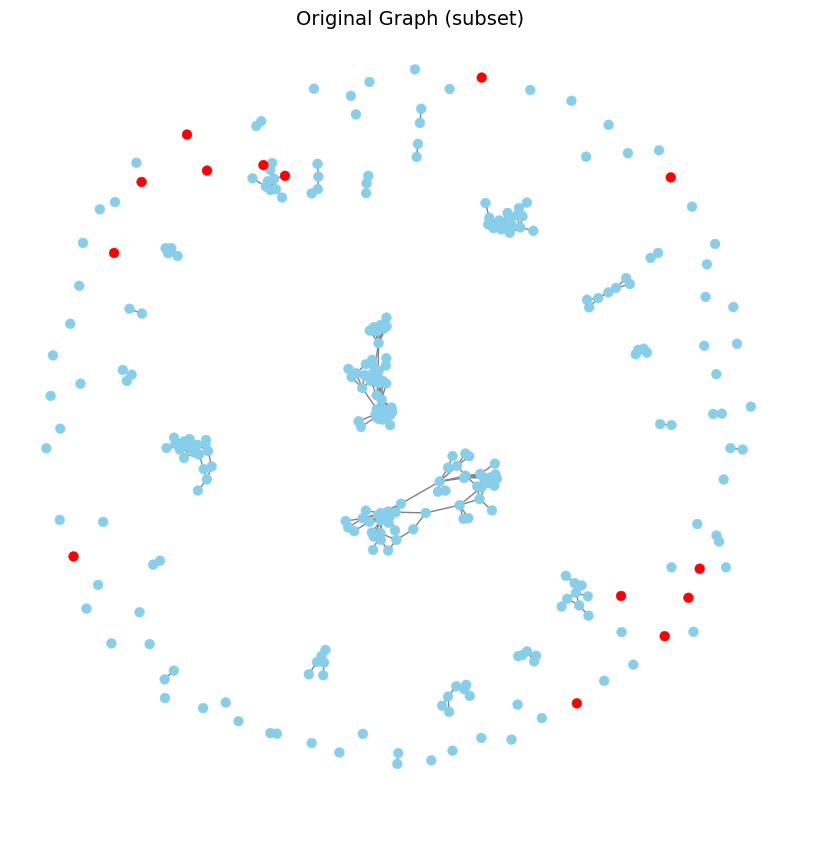

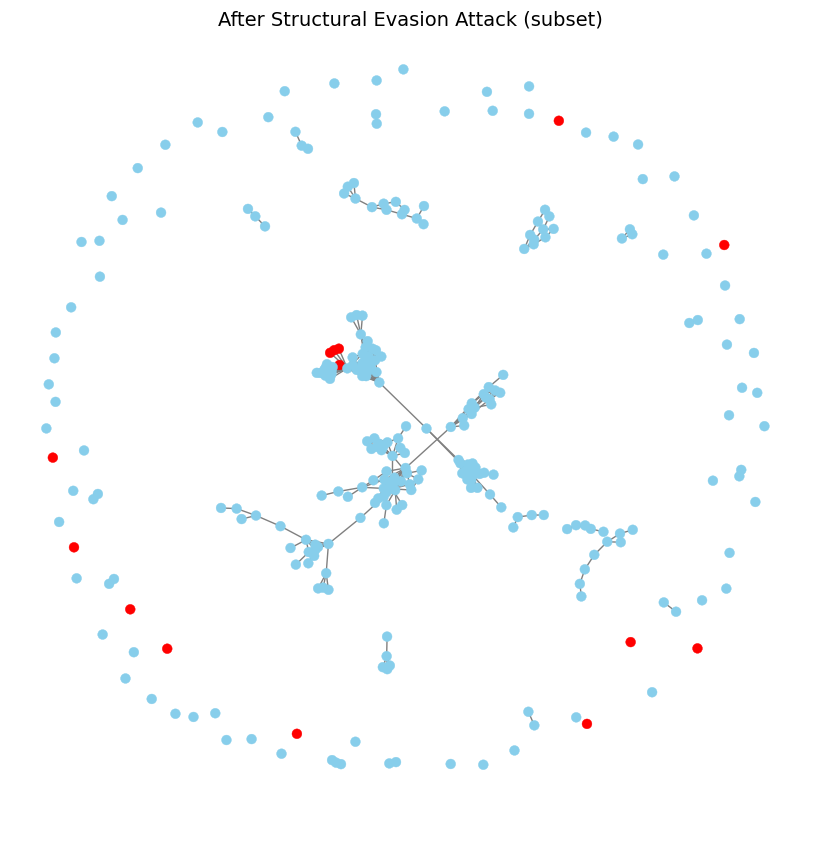

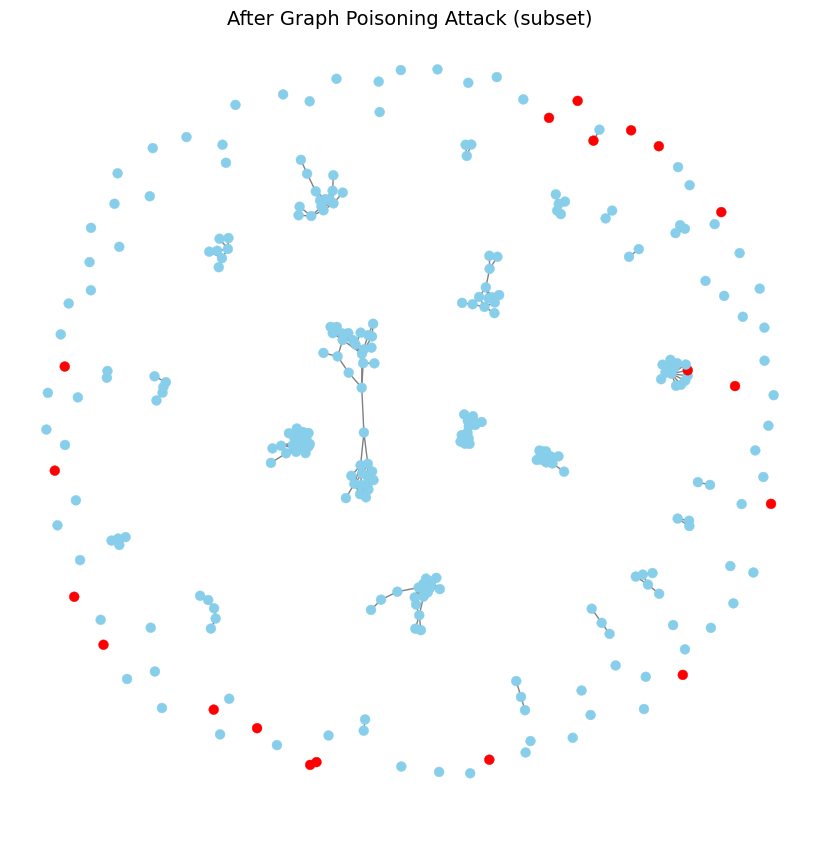

In [30]:
visualize_graph_subset(G, bot_nodes_set, num_nodes=300, title="Original Graph (subset)")
visualize_graph_subset(G_evasion, bot_nodes_set, num_nodes=300, title="After Structural Evasion Attack (subset)")
visualize_graph_subset(G_poison, bot_nodes_set, num_nodes=300, title="After Graph Poisoning Attack (subset)")
